In [4]:
using SemanticModels.ModelTools

In [5]:
include("../../src/modeltools/typegraph.jl")

@typegraph (macro with 1 method)

In [6]:
edgelist = @typegraph begin
    import Base: count

    """    AgentModel

    the root type for agent based models.

    See also: StateModel
    """
    abstract type AgentModel end

    """     StateModel

    holds the components of an agent based simulation using finite state machines.

    - states: a collection of distinct states an agent can occupy
    - agents: a collection of states `aᵢ = agents[i] ∈ states` indicating that agent `i` is in state `aᵢ`
    - transitions: the functions `f: states -> states`
    """
    mutable struct StateModel <: AgentModel
        states
        agents
        transitions
        loads
    end

    # +
    # Determine number of agents in a given state
    function count(sm::StateModel, state)
        return length(filter(a->(a==state), sm.agents))
    end

    # counts the number of agents
    function count(sm::StateModel)
        return length(sm.agents)
    end
    # -

    # stateload computes the fraction of agents in each state
    # it is used by tick! to update the statemodel for computing the probability of infection.
    function stateload(sm::StateModel, state::Symbol)
        return (count(sm, state)+1)/(count(sm)+1)
    end

    #     tick!(sm::StateModel)
    #
    # performs the operations that need to happen once per time step. Things like caching values that need to be computed at the beginning of the timestep like the distribution of the agents' states.

    function tick!(sm::StateModel)
        sm.loads = map(s->stateload(sm, s), sm.states)
    end

    #     step!(sm::StateModel, n=1)
    #
    # advance the simulation by `n` ticks of time.
    # This is an in-place operation that modifies the current state of the simulation.
    #

    function step!(sm::StateModel, n)
        for s in 1:n
          tick!(sm)
          for (i, a) in enumerate(sm.agents)
              sm.agents[i] = sm.transitions[a](sm, i,a)
          end
            describe(sm)
        end
        return sm
    end

    """    describe(sm::StateModel)

    summarize the state of the simulation for presentation or analysis.
    """
    function describe(sm::StateModel)
        counts = zeros(Int, size(sm.states))
        d = Dict{eltype(sm.states), Int}()
        for (i,s) in enumerate(sm.states)
            d[s] = i
        end
        for a in sm.agents
            i = d[a]
            counts[i] += 1
        end
        return collect(map(x->Pair(x...), zip(sm.states, counts)))
    end



    # ## Run the model
    #
    # This script defines a basic agent based model of disease spread called SIRS. Each agent is in one of 3 states
    #
    # 1. $S$ Susceptible
    # 2. $I$ Infected
    # 3. $R$ Recovered
    #
    # <img src="https://docs.google.com/drawings/d/e/2PACX-1vSeA7mAQ-795lLVxCWXzbkFQaFOHMpwtB121psFV_2cSUyXPyKMtvDjssia82JvQRXS08p6FAMr1hj1/pub?w=1031&amp;h=309">
    #
    # The agents go from `S->I`, `I-R`, and `R->S` based on random numbers. The probability of S-> is dependent on the fraction of agents in state :I. The probability of recovering is a constant ρ, and the disease confers some temporary immunity with probability μ.
    #
    # This script has an entrypoint to call it so that you can include this file and run as many simulations as you want. The intended use case is to repeatedly call `main` and accumulate the return values into an array for later analysis.

    function main(nsteps)
        n = 20
        a = fill(:S, n)
        ρ = 0.5 + randn(Float64)/4 # chance of recovery
        μ = 0.5 # chance of immunity
        T = Dict(
            :S=>(x...)->rand(Float64) < stateload(x[1], :I) ? :I : :S,
            :I=>(x...)->rand(Float64) < ρ ? :I : :R,
            :R=>(x...)->rand(Float64) < μ ? :R : :S,
        )


        sam = StateModel([:S, :I, :R], a, T, zeros(Float64,3))
        newsam = step!(deepcopy(sam), nsteps)
        @show newsam.agents
        counts = describe(newsam)
        return newsam, counts
    end

    # +
    # # An example of how to run this thing.
    main(10)
    # -

    end

newsam.agents = Symbol[:I, :S, :I, :R, :S, :R, :I, :I, :I, :R, :I, :R, :S, :I, :I, :I, :S, :S, :R, :I]


376-element Array{Any,1}:
 Edge{String,Array{DataType,1},DataType}("count", DataType[StateModel, Symbol], Int64)                                
 Edge{String,Array{DataType,1},DataType}("count", DataType[StateModel], Int64)                                        
 Edge{String,Array{DataType,1},DataType}("stateload", DataType[StateModel, Symbol], Float64)                          
 Edge{String,Array{DataType,1},DataType}("count", DataType[StateModel, Symbol], Int64)                                
 Edge{String,Array{DataType,1},DataType}("count", DataType[StateModel], Int64)                                        
 Edge{String,Array{DataType,1},DataType}("stateload", DataType[StateModel, Symbol], Float64)                          
 Edge{String,Array{DataType,1},DataType}("count", DataType[StateModel, Symbol], Int64)                                
 Edge{String,Array{DataType,1},DataType}("count", DataType[StateModel], Int64)                                        
 Edge{String,Array{Dat

In [7]:
E = unique((f.func, f.args, f.ret) for f in edgelist)

6-element Array{Tuple{String,Array{DataType,1},DataType},1}:
 ("count", [StateModel, Symbol], Int64)                                
 ("count", [StateModel], Int64)                                        
 ("stateload", [StateModel, Symbol], Float64)                          
 ("describe", [StateModel], Array{Pair{Symbol,Int64},1})               
 ("tick!", [StateModel], StateModel)                                   
 ("tick!", [StateModel], Tuple{StateModel,Array{Pair{Symbol,Int64},1}})

In [9]:
using MetaGraphs;
using LightGraphs;

In [10]:
g = MetaDiGraph();
set_indexing_prop!(g,:label);

In [11]:
for e in E
    try
        add_vertex!(g,:label,e[2]) # add ags
    catch
        nothing
    end
    
    try
        add_vertex!(g,:label,e[3]) # add rets
    catch
        nothing
    end
    
    try
        add_edge!(g,g[e[2],:label],g[e[3],:label],:label,e[1]) # add func edges
    catch
        nothing
    end
end

In [15]:
savegraph("exampletypegraph.dot",g,DOTFormat());

In [16]:
run(`dot -Tsvg -O exampletypegraph.dot`);

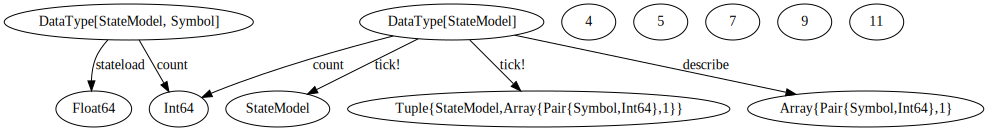

In [24]:
s = read("exampletypegraph.dot.svg",String);
display("image/svg+xml",s)

In [ ]:
# TODO use a different script and repeat, extraction, drawing, and rendering

In [ ]:
# TODO discuss difference in type graphs